# **UMARV Computer Vision YOLOv8 Segmentation Model Training Notebook**

Before you begin:


*   Select Runtime > Change Runtime Type > T4 GPU > Save





In [ ]:
#verify the GPU is working by observing the Tesla T4 slot
!nvidia-smi

Thu Aug  8 15:52:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Overview
The backbone of any machine learning model is data, it is what is used to train each model to perform various tasks. In this case we are doing driveable area segmentation and this notebook will walk you through how to train a YOLOv8 model to achieve this task.

In the majority of machine learning situations you need to provide the model with a dataset that contains both features and labels. A Feature is the raw data, in this case that is a picture with lane lines and potholes in it. Labels are what the model uses to check if its predictions are good (a ground truth), in this case that is the driveable area that we have labeled inbetween lane lines. On a high level, the model will attempt to predict the correct driveable area in a picture (feature), check how good the prediction is against the groud truth (label), and then make adjustments to get better and better results.

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, past UMARV members have put together a good dataset for our use. This dataset is hosted on Roboflow which is a website that makes dataset creation as easy as possible.

## Downloading Dataset

Visit this [link](https://universe.roboflow.com/arv-ysash/drivable-pothole-model/dataset/7/download) and create a roboflow account.

Feel free to look around the dataset and the Roboflow dashboard. When you are ready, visit the Dataset section and select a version. Here you can see additional information:

- Train/validation/test splits: Splitting up the data into three different sections is customary and each section serves a different purpose.
 - Training set: This is the set that is used to train the dataset. It is fed through the model repeatedly throughout the training process so that the model can learn the patterns. Generally you want the training set to be as large as possible while still making the val/test sets representative of the entire dataset.
 - Validation set: This set is used to track the model accuracy throughout the training process. This data is never used to train the model but instead the model will make predictions and measure the accuracy to give the user an idea of how much the model has learned. You want to make sure this set has a wide variety of data so that it will give an accurate estimation on the model performance.
 - Test set: This set is only used after the training process to evaluate multiple trained models against each other. For example, you may train 3 seperate models with a different set of training parameters and then use a common test set to see which one performes best.
- Preprocessing: These affects are applied to the entire dataset and can help with training effeciency (resizing) among other things that you may want to change before training (grayscale vs color).
- Augmentations: These are affects applied to a fraction of the dataset and allow for an increase in the dataset size. For example, you may apply noise to images so your dataset will then contain the original images plus the same images with noise applied. Using these augmentations are important in our usecase because our robot is not perfectly stable nor is our camera perfectly clear, so often we have to make predictions are images that are imperfect.

Now that you know what goes into creating a dataset you are ready to download it and train a model! On the Dataset page visit:
- Download Dataset > YOLOv8 > show download code > continue > Copy the code.
- Paste the code in the cell below where it directs you.

In [ ]:
import os
HOME = os.getcwd()
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install ultralytics==8.0.196 --quiet
import ultralytics


# REPLACE: Replace with download snippet recieved from Roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IK4FwoCfj6isjX4tvSlJ")
project = rf.workspace("arv-ysash").project("drivable-pothole-model")
version = project.version(7)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drivable/Pothole-Model-7 in yolov8:: 100%|██████████| 6091/6091 [00:01<00:00, 5044.85it/s]


## Training

Below is the command that will begin training a model with the dataset you have just uploaded. Here is some preliminary information that can help explain what is happening throughout the training process.

1. Transfer Learning: Transfer learning is a type of training where you start with a general model and use your custom dataset to adjust what is it predicts. This works by assuming the networks use similar high level strucutres such as corners and edges to identify things in the frame. These high level detections are done in early layers of the networks so we can leave those layers alone and simply adjust the later layers to detect driveable area rather than what the base model detects. By doing this you can get away with a much smaller dataset and worse hardware which results in shorter learning times. [Here](https://docs.ultralytics.com/models/yolov8/#supported-tasks-and-modes) are the models that you can use for transfer learning and you simply change model parameter below to apply the correct base model.
2. Parameter Values: Training can be customized based on a list of parameters which can be found under training settings when you visit this [link](https://docs.ultralytics.com/usage/cfg/). Each will affect how the model trains. I recommend sticking with the default values at first and then begin adjusting them to see if you gain better performance.
3. Training Output: Once you click play there will be output given for each epoch (run through the dataset). You can observe a list of loss values (box_loss, seg_loss, cls_loss) which are all measures of accuracy by the model that you want to see go down overtime which proves that the model is actively learning patterns and predicting more and more accuratley. One other metric to keep an eye on is the [mAP](https://www.v7labs.com/blog/mean-average-precision) value which is another common accuracy measure that you want to get as high as possible.

Once you are set with your parameter values you are ready to train. Your final model will be stored in /runs/segment/train/weights/best.pt and you can download this model for future use.


In [ ]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=3 imgsz=640

/content
New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/Drivable/Pothole-Model-7/data.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=No

## Analysis

Here is some more information on the various metrics that are measured throughout the training process. Some things you want to look out for is that your validation losses are always on the downslope. If they begin to go up you have likely overfit the model and should adjust parameters.

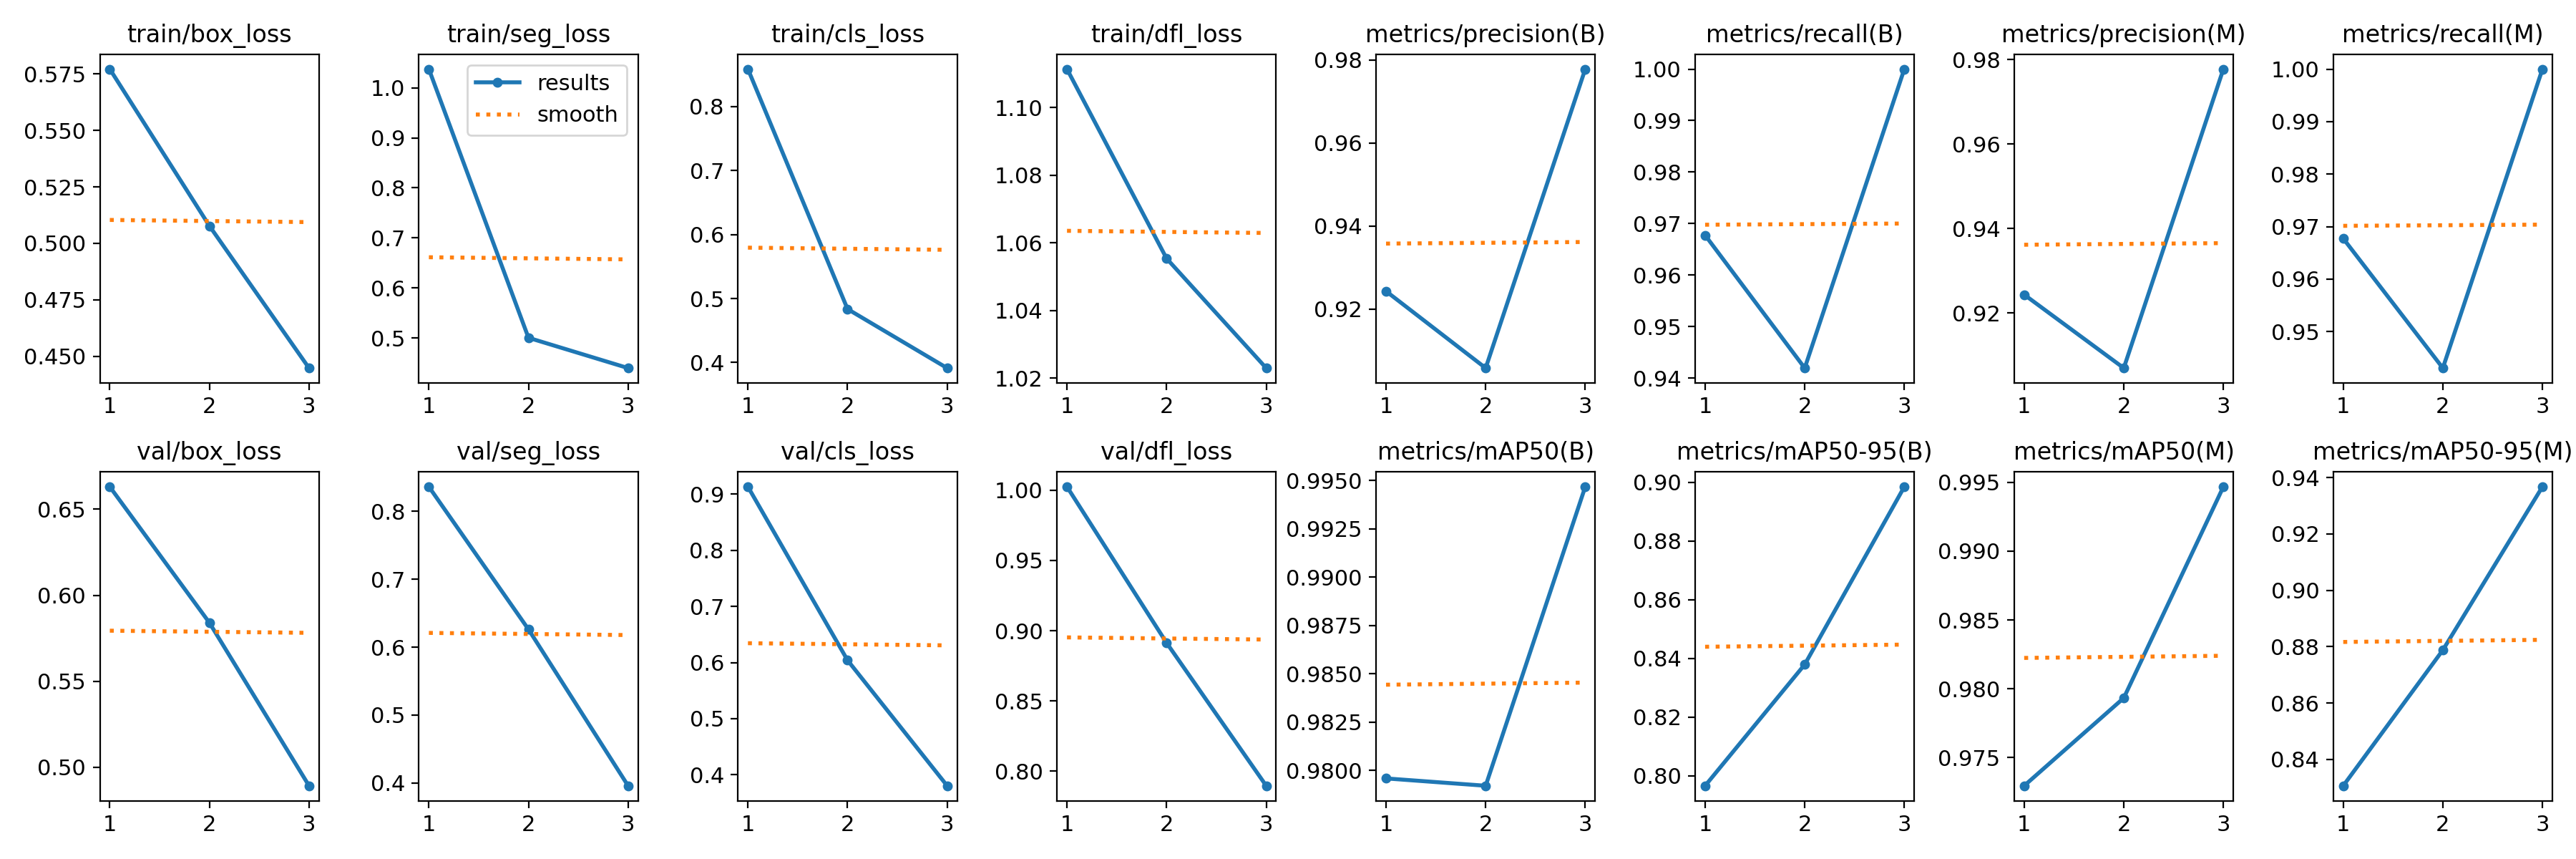

In [ ]:
from IPython.display import display, Image
Image(filename=f'{HOME}/runs/segment/train2/results.png', width=600)

Here you can see some of the output your model is getting on the validation set. This is a good sanity check to verify everything during the training process went smoothly. These outputs generally looks far better than what the model will output during a full test.

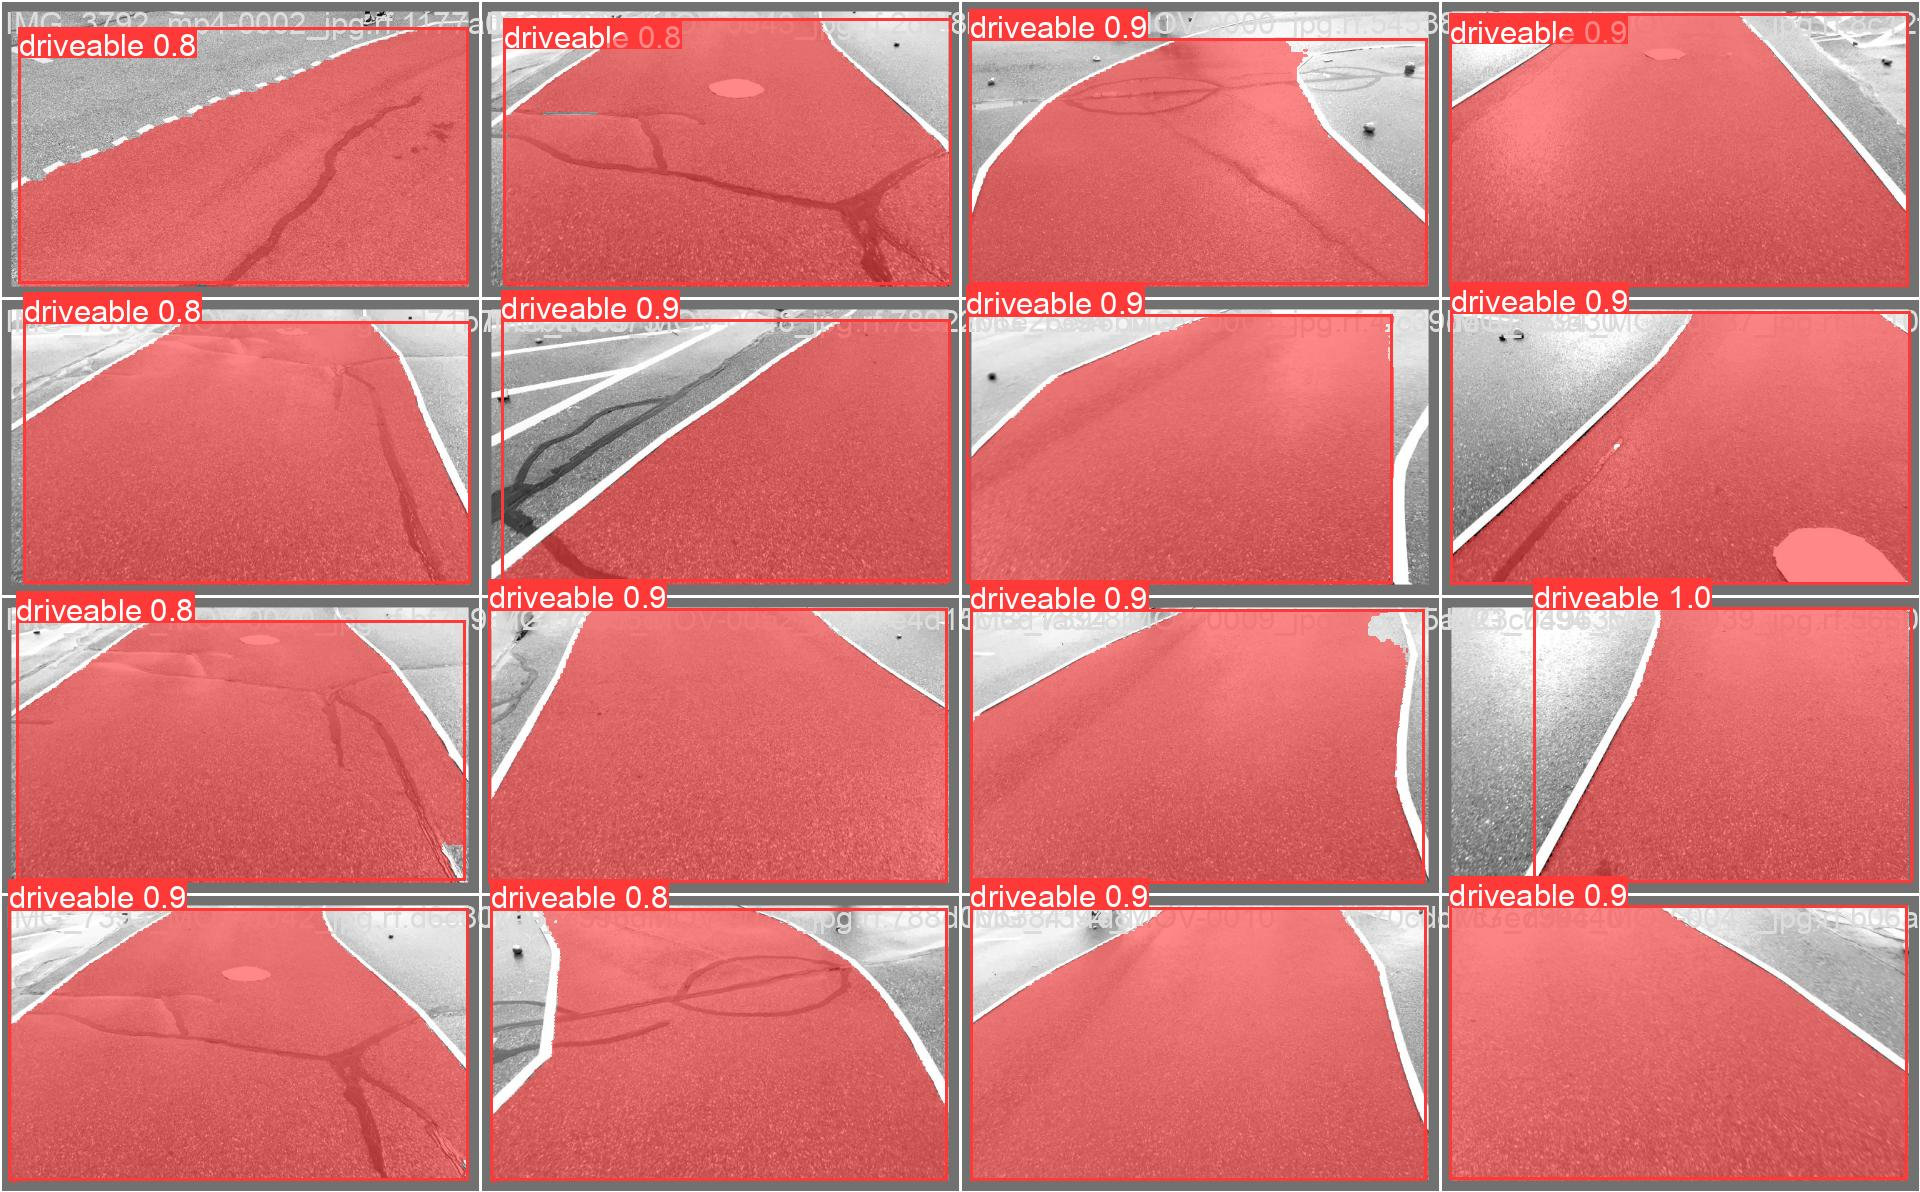

In [ ]:
#If you have done more than one training in the same notebook instance
#you will need to change the file path to match the correct training number
# For example the output for your second training will be at /runs/segment/train2/val_batch0_pred.jpg'
Image(filename=f'{HOME}/runs/segment/train2/val_batch0_pred.jpg', width=600)

This is a command to do some more validation on the model. Outputs metric values/graphs, and visual predictions.

In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs
val: Scanning /content/datasets/Drivable/Pothole-Model-7/valid/labels.cache... 155 images, 0 backgrounds, 0 corrupt: 100% 155/155 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 10/10 [00:05<00:00,  1.68it/s]
                   all        155        155      0.978          1      0.995      0.896      0.978          1      0.995      0.939
Speed: 2.7ms preprocess, 8.3ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val
